In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D

import theano
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Windows-10-10.0.19041-SP0


In [3]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.1.0


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
PROJECT_DIR = 'D:/archive'

In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1



In [6]:
IMG_SIZE = 128
ColorChannels = 3
IMG_DEPTH = 16
skip = False

X_tr=[]    

In [7]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia


def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success and count < IMG_DEPTH:
            # skipping frames to avoid duplications 
            if (ID % 2 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                #image_aug = flip(image = image)
                #image_aug = random_brightness(image = image_aug)
                #image_aug = zoom(image = image_aug)
                #image_aug = rotate(image = image_aug)
                
                #rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                count += 1
        else:
            break
    
    vidcap.release() 

    ipt=np.rollaxis(np.rollaxis(np.array(ImageFrames),2,0),2,0)
    ipt=np.rollaxis(ipt,2,0)

    if len(ipt) < 15:
      print('kurang')

    return [ipt]

In [8]:
%%time
from tqdm import tqdm

num_samples = 600
total_samples = num_samples * 2


VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

#print('i choose \n{} videos out of 2000, cuz of memory issue').format(num_samples)
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:num_samples])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

we have 
1000 Violence videos 
1000 NonViolence videos


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:51<00:00, 11.71it/s]

Wall time: 1min 30s


In [9]:
train_data = [np.array(X_original),y_original]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

train_set = np.zeros((total_samples, IMG_DEPTH, IMG_SIZE,IMG_SIZE,3))

for h in range(total_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]
  

patch_size = 16    # img_depth or number of frames used for each video

print(train_set.shape, 'train samples')

X_Train shape: (1200, 16, 128, 128, 3)
(1200, 16, 128, 128, 3) train samples


In [10]:
print("a")

a


In [11]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, len(CLASSES))

In [12]:
# Pre-processing

train_set = train_set.astype('float32')
print(np.mean(train_set))
train_set -= np.mean(train_set)
print(np.max(train_set))
train_set /=np.max(train_set)

93.033585
161.96642


In [13]:
import keras
# Define model
#high resolution network
from keras.regularizers import l2
weight_decay = 0.005
# Init
model = Sequential()

model.add(Conv3D(4, kernel_size=(3, 3, 3), input_shape=(patch_size, IMG_SIZE, IMG_SIZE, 3),padding='same', bias_initializer='ones', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D())

model.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=(patch_size, IMG_SIZE, IMG_SIZE, 3),padding='same', bias_initializer='ones', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D())

model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(patch_size, IMG_SIZE, IMG_SIZE, 3),padding='same', bias_initializer='ones', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D())

model.add(Conv3D(64, kernel_size=(3, 3, 3), input_shape=(patch_size, IMG_SIZE, IMG_SIZE, 3),padding='same', bias_initializer='ones', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D())

model.add(Flatten())

model.add(Dense(512, activation='relu', bias_initializer='ones', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(216, activation='relu', bias_initializer='ones', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(len(CLASSES), kernel_initializer='normal',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Activation('softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 128, 128, 4)   328       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 128, 128, 4)   16        
_________________________________________________________________
activation_1 (Activation)    (None, 16, 128, 128, 4)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 64, 64, 4)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 64, 64, 8)      872       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 64, 64, 8)      32        
_________________________________________________________________
activation_2 (Activation)    (None, 8, 64, 64, 8)     

In [15]:
import os
#os.chdir('///home/jovyan/program/DL/11_1下tensorflow_simpson')
save_dir = os.path.join(os.getcwd(),'saved_model')
print(os.getcwd())
model_name = "3DCNN_Week1_1200"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

D:\


In [16]:
sgd = SGD(lr=0.001,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              metrics=['acc'])

In [17]:
X_train, X_test, y_train,y_test = train_test_split(train_set, Y_train, test_size=0.3, random_state=20)

In [18]:
batch_size = 32
nb_epoch =100
#steps_per_epoch=int((len(X_test)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.00001, 
                               cooldown=0, patience=2, min_lr=0.005/(2^4))
hist = model.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test),
    batch_size=batch_size,
    epochs = nb_epoch,
    shuffle=True,
    callbacks=[checkpoint,lr_reducer]
    )

Train on 840 samples, validate on 360 samples
Epoch 1/100
840/840 [==============================] - 26s 31ms/step - loss: 20.0840 - acc: 0.4786 - val_loss: 19.7222 - val_acc: 0.4917

Epoch 00001: val_acc improved from -inf to 0.49167, saving model to D:\saved_model\3DCNN_Week1_1200
Epoch 2/100
840/840 [==============================] - 8s 10ms/step - loss: 19.7534 - acc: 0.5036 - val_loss: 19.4958 - val_acc: 0.5083

Epoch 00002: val_acc improved from 0.49167 to 0.50833, saving model to D:\saved_model\3DCNN_Week1_1200
Epoch 3/100
840/840 [==============================] - 8s 10ms/step - loss: 19.4801 - acc: 0.5107 - val_loss: 19.2904 - val_acc: 0.4917

Epoch 00003: val_acc did not improve from 0.50833
Epoch 4/100
840/840 [==============================] - 8s 10ms/step - loss: 19.2076 - acc: 0.5524 - val_loss: 19.1558 - val_acc: 0.5083

Epoch 00004: val_acc did not improve from 0.50833
Epoch 5/100
840/840 [==============================] - 8s 10ms/step - loss: 19.0554 - acc: 0.5167 - va

840/840 [==============================] - 8s 10ms/step - loss: 12.6739 - acc: 0.8810 - val_loss: 12.7666 - val_acc: 0.8111

Epoch 00041: val_acc did not improve from 0.83889
Epoch 42/100
840/840 [==============================] - 8s 10ms/step - loss: 12.5132 - acc: 0.9000 - val_loss: 12.5929 - val_acc: 0.8333

Epoch 00042: val_acc did not improve from 0.83889
Epoch 43/100
840/840 [==============================] - 8s 10ms/step - loss: 12.3520 - acc: 0.9083 - val_loss: 12.6371 - val_acc: 0.7944

Epoch 00043: val_acc did not improve from 0.83889
Epoch 44/100
840/840 [==============================] - 8s 10ms/step - loss: 12.2120 - acc: 0.9190 - val_loss: 12.3874 - val_acc: 0.8361

Epoch 00044: val_acc did not improve from 0.83889
Epoch 45/100
840/840 [==============================] - 8s 10ms/step - loss: 12.0694 - acc: 0.9214 - val_loss: 12.2399 - val_acc: 0.8389

Epoch 00045: val_acc did not improve from 0.83889
Epoch 46/100
840/840 [==============================] - 8s 10ms/step - lo

840/840 [==============================] - 8s 10ms/step - loss: 8.0712 - acc: 0.9940 - val_loss: 8.5196 - val_acc: 0.8611

Epoch 00084: val_acc did not improve from 0.86111
Epoch 85/100
840/840 [==============================] - 8s 10ms/step - loss: 7.9937 - acc: 0.9988 - val_loss: 8.4319 - val_acc: 0.8583

Epoch 00085: val_acc did not improve from 0.86111
Epoch 86/100
840/840 [==============================] - 8s 10ms/step - loss: 7.9209 - acc: 0.9976 - val_loss: 8.3666 - val_acc: 0.8583

Epoch 00086: val_acc did not improve from 0.86111
Epoch 87/100
840/840 [==============================] - 8s 10ms/step - loss: 7.8457 - acc: 1.0000 - val_loss: 8.5163 - val_acc: 0.8194

Epoch 00087: val_acc did not improve from 0.86111
Epoch 88/100
840/840 [==============================] - 8s 10ms/step - loss: 7.7752 - acc: 1.0000 - val_loss: 8.2888 - val_acc: 0.8444

Epoch 00088: val_acc did not improve from 0.86111
Epoch 89/100
840/840 [==============================] - 8s 10ms/step - loss: 7.7034

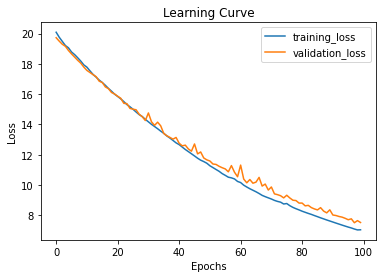

In [19]:

training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

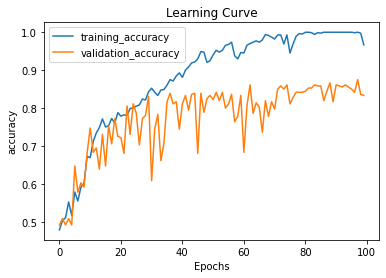

In [20]:

training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [21]:
from keras.models import Model, load_model
model1_name = "3DCNN_Week1_1200"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)

In [22]:
test_pred =model1.predict(X_train[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

[1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1]


In [23]:
img_array = X_train[70]

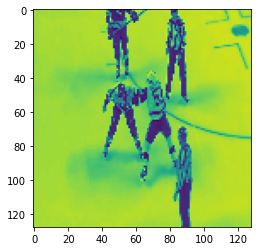

In [24]:
plt.imshow(img_array[0,:,:,1])

In [25]:
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(y_test,axis =1), np.argmax(model1.predict(X_test),axis =1))
print(met)

[[150  27]
 [ 18 165]]


In [26]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

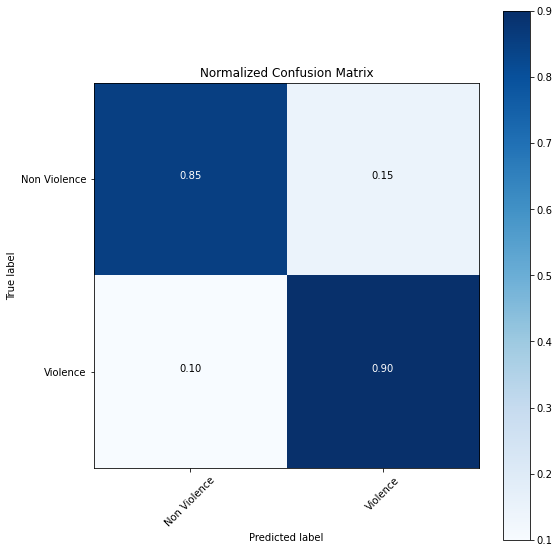

In [27]:
confusion_matrix_plot(met, classes=['Non Violence', 'Violence'])

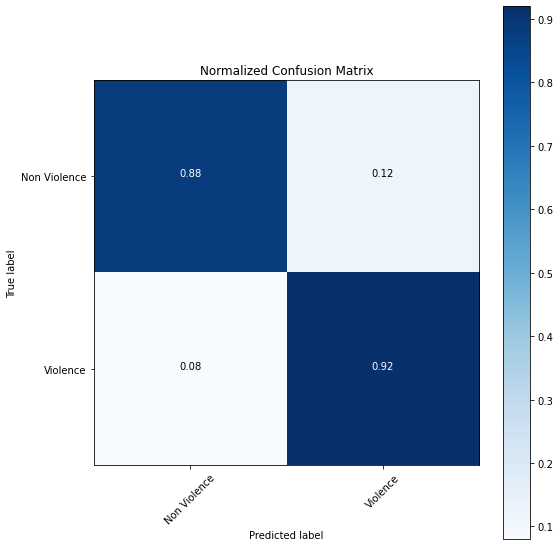

In [27]:
confusion_matrix_plot(met, classes=['Non Violence', 'Violence'])

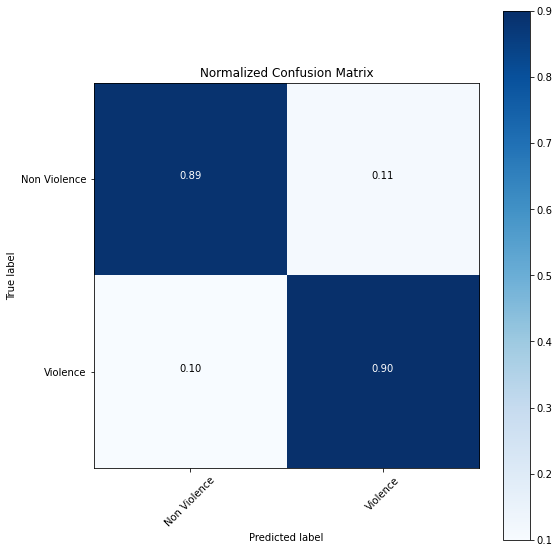

In [36]:
confusion_matrix_plot(met, classes=['Non Violence', 'Violence'])

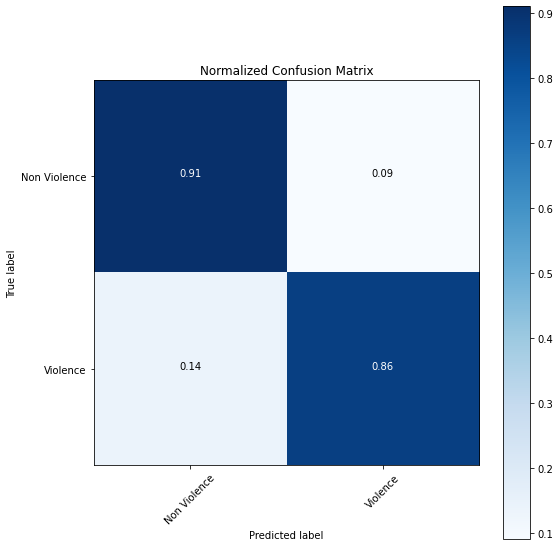

In [32]:
confusion_matrix_plot(met, classes=['Non Violence', 'Violence'])

In [28]:
#NEW 600 with L2 + CLSTM2D
precision = 165/(165+27)
recall = 165/(165+18)
f1 = 2 / (1/precision + 1/recall)

In [29]:
print(precision)
print(recall)
print(f1)

0.859375
0.9016393442622951
0.8800000000000001


In [33]:
#NEW 600 with L2 reduced
precision = 157/(157+16)
recall = 157/(157+26)
f1 = 2 / (1/precision + 1/recall)

In [34]:
print(precision)
print(recall)
print(f1)

0.9075144508670521
0.8579234972677595
0.8820224719101124


In [29]:
#NEW 600 with L2
precision = 168/(168+21)
recall = 168/(168+15)
f1 = 2 / (1/precision + 1/recall)

In [30]:
print(precision)
print(recall)
print(f1)

0.8888888888888888
0.9180327868852459
0.9032258064516129


In [43]:
#NEW 600 IMAGES
precision = 165/(165+20)
recall = 165/(165+18)
print(precision)
print(recall)
f1 = 2 / (1/precision + 1/recall)
print(f1)

0.8918918918918919
0.9016393442622951
0.8967391304347826


In [44]:
#OLD 300 IMAGES
precision = 76/(76+8)
recall = 76/(76+12)
print(precision)
print(recall)
f1 = 2 / (1/precision + 1/recall)
print(f1)

0.9047619047619048
0.8636363636363636
0.8837209302325582


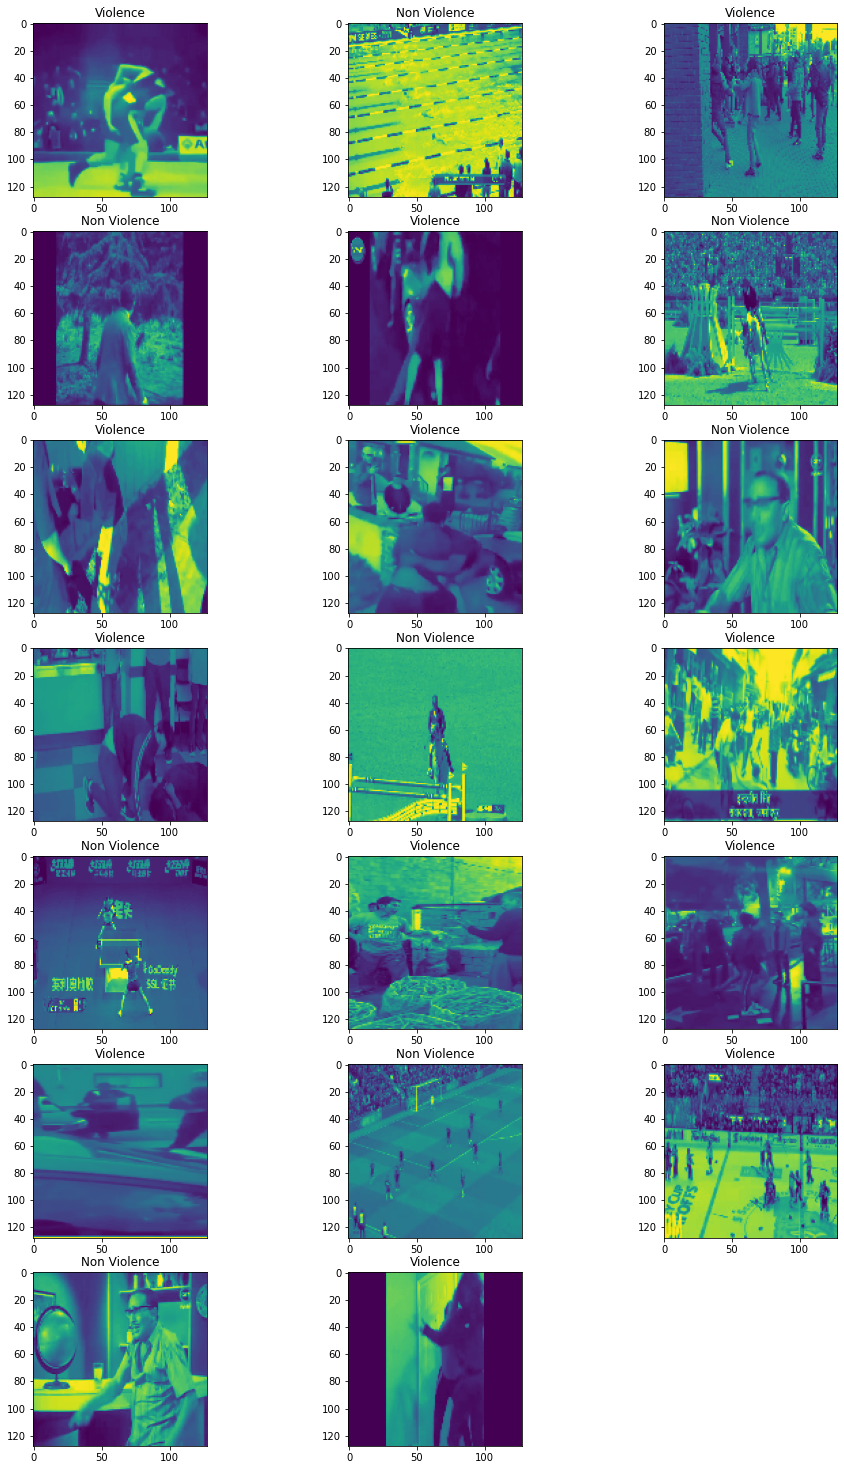

In [31]:
import numpy as np
import argparse
import pickle
import cv2
import os
import time
from keras.models import load_model
from collections import deque

fallClass = ['Non Violence', 'Violence']

fig=plt.figure(figsize=(16, 30))
count = 0
color = (255, 0, 0)

for x in range(50,70):
    count = count + 1
    test_pred =model1.predict(X_train[x:x+1])
    result = np.argmax(test_pred, axis =1)  
    img_array = X_train[x]
    imageNow = img_array[0,:,:,1]
    cv2.putText(np.array(imageNow), fallClass[result[0]], (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
    x = fig.add_subplot(8, 3, count)
    x.title.set_text(fallClass[result[0]])
    plt.imshow(imageNow)

plt.show()

In [33]:
model.save("D:/saved_model/my_modelwithl2.h5")